### Import Required Libraries and load the source Data

In [204]:
#Import Warnings Library
import warnings
warnings.filterwarnings('ignore')

In [205]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

In [206]:
#Read the Uber Request Data
request_data=pd.read_csv('Uber Request Data.csv')
request_data.head()

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp
0,619,Airport,1.0,Trip Completed,11/7/2016 11:51,11/7/2016 13:00
1,867,Airport,1.0,Trip Completed,11/7/2016 17:57,11/7/2016 18:47
2,1807,City,1.0,Trip Completed,12/7/2016 9:17,12/7/2016 9:58
3,2532,Airport,1.0,Trip Completed,12/7/2016 21:08,12/7/2016 22:03
4,3112,City,1.0,Trip Completed,13-07-2016 08:33:16,13-07-2016 09:25:47


### Data Preparation
- Cleaning Data for Missing values & convert columns to appropriate datatypes
- Deriving new Attributes

#### Assumption on Time Slots (6 slots)
- between 4 AM and before 8 AM --> 4-8 (Early Morning)
- between 8 AM and before 12 PM --> 8-12 (Morning)
- between 12 PM and before 4 PM --> 12-16 (Afternoon)
- between 4 PM and before  8 PM --> 16-20 (Evening)
- between 8 PM and before 12 AM --> 20-24 (Late Evening)
- between 12 AM and before 4 AM --> 24-04 (Late Night)

In [207]:
#Renaming the columns to underscore notation so that all fields are named consistently for ease of use later
request_data.rename(columns ={'Request id':'request_id','Pickup point':'pickup_point','Driver id':'driver_id','Status':'status','Request timestamp':'request_timestamp','Drop timestamp':'drop_timestamp'}, inplace=True)

In [208]:
#Check the data set info
print("Total Request Count: {0}".format(len(request_data.index)))

Total Request Count: 6745


In [209]:
request_data.head()

,request_id,pickup_point,driver_id,status,request_timestamp,drop_timestamp
0,619,Airport,1.0,Trip Completed,11/7/2016 11:51,11/7/2016 13:00
1,867,Airport,1.0,Trip Completed,11/7/2016 17:57,11/7/2016 18:47
2,1807,City,1.0,Trip Completed,12/7/2016 9:17,12/7/2016 9:58
3,2532,Airport,1.0,Trip Completed,12/7/2016 21:08,12/7/2016 22:03
4,3112,City,1.0,Trip Completed,13-07-2016 08:33:16,13-07-2016 09:25:47


In [210]:
#inspect the data set for missing values
(request_data.isnull().sum()/len(request_data))*100

request_id            0.000000
pickup_point          0.000000
driver_id            39.288362
status                0.000000
request_timestamp     0.000000
drop_timestamp       58.028169
dtype: float64

- Since the percentage of missing values for Driver id & Drop timestamp is quite high, It is an indicator that some of the trips were either Cancelled or may be not served due to Cars being not Available.

Lets not drop or impute these at this point. We can use this in some further analysis.

In [211]:
#help(pd.to_timedelta)

In [212]:
request_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6745 entries, 0 to 6744
Data columns (total 6 columns):
request_id           6745 non-null int64
pickup_point         6745 non-null object
driver_id            4095 non-null float64
status               6745 non-null object
request_timestamp    6745 non-null object
drop_timestamp       2831 non-null object
dtypes: float64(1), int64(1), object(4)
memory usage: 316.2+ KB


In [213]:
#Convert Request_timestamp to proper datatype
request_data['request_timestamp'] = pd.to_datetime(request_data['request_timestamp'])
request_data['drop_timestamp'] = pd.to_datetime(request_data['drop_timestamp'])

In [214]:
#Derive additional Date fields from Request_timestamp to see the exact times when a ride was requested
request_data['day'] = request_data['request_timestamp'].dt.day    #Day of the month like 12,13
request_data['month'] = request_data['request_timestamp'].dt.month   #Month like January February
request_data['year'] = request_data['request_timestamp'].dt.year    #Year like 2019, 2018
request_data['hour'] = request_data['request_timestamp'].dt.hour   #Hour of the day like 06, 11, 18, 20
request_data['weekday'] = request_data['request_timestamp'].dt.strftime('%A')    #Weekday like Monday, Tuesday
request_data.head()

,request_id,pickup_point,driver_id,status,request_timestamp,drop_timestamp,day,month,year,hour,weekday
0,619,Airport,1.0,Trip Completed,2016-11-07 11:51:00,2016-11-07 13:00:00,7,11,2016,11,Monday
1,867,Airport,1.0,Trip Completed,2016-11-07 17:57:00,2016-11-07 18:47:00,7,11,2016,17,Monday
2,1807,City,1.0,Trip Completed,2016-12-07 09:17:00,2016-12-07 09:58:00,7,12,2016,9,Wednesday
3,2532,Airport,1.0,Trip Completed,2016-12-07 21:08:00,2016-12-07 22:03:00,7,12,2016,21,Wednesday
4,3112,City,1.0,Trip Completed,2016-07-13 08:33:16,2016-07-13 09:25:47,13,7,2016,8,Wednesday


 - Now that we know the exact hour of the day when the cab was requested, we can bucket it in appropriate category like early morning, afternoon, evening etc.

In [215]:
#help(pd.cut)

Bucket Trip Request Time in following Time slots
- between 4 AM and before 8 AM --> 4-8 (Early Morning)
- between 8 AM and before 12 PM --> 8-12 (Morning)
- between 12 PM and before 4 PM --> 12-16 (Afternoon)
- between 4 PM and before  8 PM --> 16-20 (Evening)
- between 8 PM and before 12 AM --> 20-24 (Late Evening)
- between 12 AM and before 4 AM --> 24-04 (Late Night)

In [216]:
#Classify the request time hour into buckets
request_data['time_slot'] = pd.cut(request_data['hour'],bins=[0,4,8,12,16,20,24],labels=['Late Night','Early Morning','Morning','Afternoon','Evening','Late Evening'])
request_data.head()

,request_id,pickup_point,driver_id,status,request_timestamp,drop_timestamp,day,month,year,hour,weekday,time_slot
0,619,Airport,1.0,Trip Completed,2016-11-07 11:51:00,2016-11-07 13:00:00,7,11,2016,11,Monday,Morning
1,867,Airport,1.0,Trip Completed,2016-11-07 17:57:00,2016-11-07 18:47:00,7,11,2016,17,Monday,Evening
2,1807,City,1.0,Trip Completed,2016-12-07 09:17:00,2016-12-07 09:58:00,7,12,2016,9,Wednesday,Morning
3,2532,Airport,1.0,Trip Completed,2016-12-07 21:08:00,2016-12-07 22:03:00,7,12,2016,21,Wednesday,Late Evening
4,3112,City,1.0,Trip Completed,2016-07-13 08:33:16,2016-07-13 09:25:47,13,7,2016,8,Wednesday,Early Morning


### Data Analysis for each Attribute
Lets now move on to analysing the attributes and seeing what influences the other
 - We can check various metrics like how many requests get fulfilled, cancelled or not served due to unavailability of the cars

In [217]:
#request_data.status.unique()

In [218]:
grouped_request_data = request_data.groupby(by=['pickup_point','status','time_slot'], as_index=False).request_id.count()
grouped_request_data.rename(columns={'request_id':'#_of_requests'},inplace=True)
grouped_request_data

,pickup_point,status,time_slot,#_of_requests
0,Airport,Cancelled,Late Night,2
1,Airport,Cancelled,Early Morning,15
2,Airport,Cancelled,Morning,32
3,Airport,Cancelled,Afternoon,40
4,Airport,Cancelled,Evening,78
5,Airport,Cancelled,Late Evening,31
6,Airport,No Cars Available,Late Night,118
7,Airport,No Cars Available,Early Morning,14
8,Airport,No Cars Available,Morning,44
9,Airport,No Cars Available,Afternoon,50


In [219]:
#help(sns.countplot)

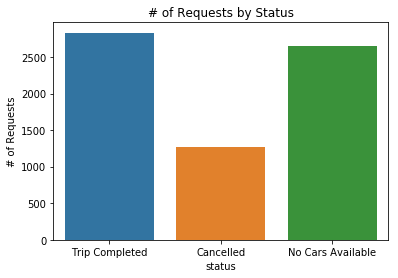

In [220]:
#Lets visualize the count of requests for each of the trip statuses and see
plt.title('# of Requests by Status')
sns.countplot(x='status', data=request_data)
plt.ylabel('# of Requests')
plt.show()

We see from above that more than 50% of the requests (1264 + 2650 = 3914) were not fulfilled as the trip was either cancelled or the cars were unavailable.

In [221]:
#Lets also see the average trip time of the succesful rides and see if that influences any KPI
drop_ts = request_data.loc[~pd.isnull(request_data['drop_timestamp']),['pickup_point','request_timestamp','drop_timestamp','time_slot']]

drop_ts['trip_time'] = (pd.to_timedelta(drop_ts['drop_timestamp']) - pd.to_timedelta(drop_ts['request_timestamp']))
drop_ts['trip_time'] = pd.to_datetime(drop_ts['trip_time']).dt.strftime('%H:%M:%S')
drop_ts['trip_time_in_seconds'] = (drop_ts['trip_time'].apply(lambda f: f.split(':'))).apply(lambda f: int(f[0])*3600 + int(f[1])*60 + int(f[2]))
avg_trip_time = drop_ts.groupby(['pickup_point','time_slot'],as_index=False)['trip_time_in_seconds'].mean()
avg_trip_time['trip_time_in_seconds'] = pd.to_timedelta(avg_trip_time['trip_time_in_seconds'],unit='s')
avg_trip_time.rename(columns={'trip_time_in_seconds':'avg_trip_time_in_seconds'},inplace=True)
avg_trip_time

,pickup_point,time_slot,avg_trip_time_in_seconds
0,Airport,Late Night,00:53:22.287500
1,Airport,Early Morning,00:51:10.762987
2,Airport,Morning,00:53:13.192469
3,Airport,Afternoon,00:51:29.234568
4,Airport,Evening,00:52:07.766026
5,Airport,Late Evening,00:52:54.911330
6,City,Late Night,00:54:17.106383
7,City,Early Morning,00:53:12.455764
8,City,Morning,00:52:43.919580
9,City,Afternoon,00:52:31.822115


- The average trip time for any trip is ~50 minutes which is not so fluctuating. So this does not seem to be influencing the denial of requests

Lets dig deeper into analysing the Status of these requests from different pickup points

<function matplotlib.pyplot.show(*args, **kw)>

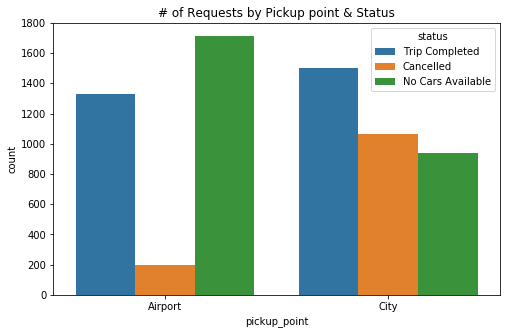

In [222]:
#Number of Requests by pickup point and status
plt.figure(figsize=(8,5))
sns.countplot(x='pickup_point',data=request_data,hue='status')
plt.title('# of Requests by Pickup point & Status')
plt.show

The above plot reveals 2 insights:
- Most of the requests at the Aiport that go unfulfilled are due to unavailability of the cars while a few get cacelled
- Out of all unfulfilled requests in City area, most of them are cancelled that result in unavailability of Cars at the Airport. Quite a considerable count of requests also go unfulfilled due to No Cars Available

Lets see more what is the usual time when these requests are either cancelled or show No Cars available

In [223]:
#Lets focus on the trips that were not fulfilled (status != 'Trip Completed')
request_data_unfulfilled = request_data.loc[request_data.status!='Trip Completed']

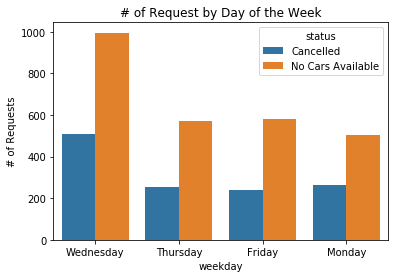

In [224]:
plt.title('# of Request by Day of the Week')
sns.countplot(x='weekday',data=request_data_unfulfilled,hue='status')
plt.ylabel('# of Requests')
plt.show()

As we see in the above plot, the number of requests show higher on Wednesday. But everyday the ratio of unfulfilled requests is almost the same. So even week of the day does not seem to be an influencing factor.

Now lets go one level deeper and see what hour of the day do the maximum requests suffer denial.

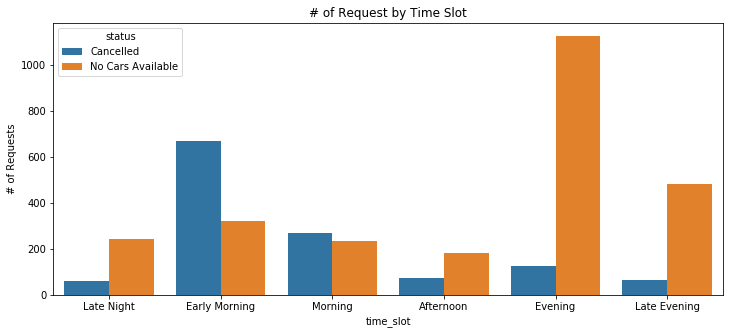

In [225]:
plt.figure('# of Request by Time Slot',figsize=(12,5))
plt.title('# of Request by Time Slot')

sns.countplot(x='time_slot',data=request_data_unfulfilled,hue='status')
plt.ylabel('# of Requests')
plt.show()

As we see in the above figure the number of cars that are available reduces in evening & late evening noon. This is quite a huge supplydemand gap. Quite a high number of requests get cancelled during Early Morning.

Lets check one more aspect of the nature of these requests: Avaialbility of Cars/Status of trips during various time slots at different pick up points

In [226]:
#help(plt.figure)
#help(plt.subplot)

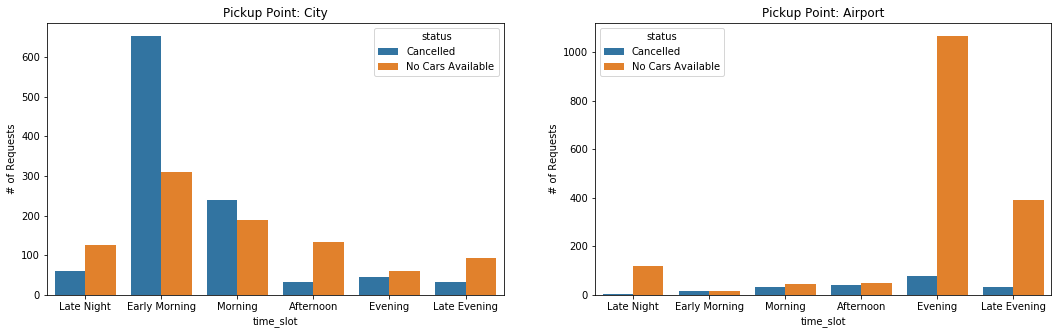

In [227]:
plt.figure('Timeslot Analysis',figsize=(18,5))
#plt.title('# of Request & their Status')
plt.subplot(1,2,1)
sns.countplot(x='time_slot',data=(request_data_unfulfilled.loc[request_data['pickup_point']=='City']),hue='status')
plt.title("Pickup Point: City")
plt.ylabel('# of Requests')

plt.subplot(1,2,2)
sns.countplot(x='time_slot',data=(request_data_unfulfilled.loc[request_data['pickup_point']=='Airport']),hue='status')
plt.title("Pickup Point: Airport")
plt.ylabel('# of Requests')

plt.show()

- A large number of requests from City to Airport get cancelled during the Early Morning and Morning hours(4 AM to 12 PM). This could be due to less number of flights landing during that time, so the Drivers do not really want to take a trip headed to the Airport as they are less likely to get a return trip or Drivers not at work yet
   
- The above chart also tells us that the maximum number of trip requests at the Airport are seen in the Evening & late Evenings (4 PM to 12 AM) probably because a lot of flights land at that time. But the number of requests that go unfulfilled is very high. So the Demand is way higher than the Supply of cars at the Airport at this time.


### Demand Supply Analysis
- Demand is the Total number of requests made
- Supply is the Total number of Cars made available to fulfill the requests
- Gap = Demand - Supply

In [228]:
#Find out the Total Supply i.e., Number of trips completed
Supply_df = request_data.loc[request_data.status=='Trip Completed'].groupby(by=['pickup_point','time_slot'], as_index=False)['request_id'].count()
Supply_df.rename(columns = {'request_id':'supply'}, inplace=True)
Supply_df.sort_values(by=['pickup_point','supply'],ascending=[True,False])

,pickup_point,time_slot,supply
4,Airport,Evening,312
1,Airport,Early Morning,308
2,Airport,Morning,239
5,Airport,Late Evening,203
3,Airport,Afternoon,162
0,Airport,Late Night,80
7,City,Early Morning,373
10,City,Evening,330
8,City,Morning,286
9,City,Afternoon,208


In [229]:
#Find out the Total Demand i.e., Trips with all Status
Demand_df = request_data.groupby(by=['pickup_point','time_slot'],as_index=False)['request_id'].count()
Demand_df.rename(columns = {'request_id':'demand'}, inplace=True)
Demand_df.sort_values(by=['pickup_point','demand'],ascending=[True,False])

,pickup_point,time_slot,demand
4,Airport,Evening,1457
5,Airport,Late Evening,624
1,Airport,Early Morning,337
2,Airport,Morning,315
3,Airport,Afternoon,252
0,Airport,Late Night,200
7,City,Early Morning,1335
8,City,Morning,714
10,City,Evening,436
9,City,Afternoon,374


In [230]:
#help(pd.DataFrame.groupby)

In [231]:
#Merge the Demand & Supply Dataframes to get an overall picture of Supply_Demand gap
Demand_Supply_df = pd.merge(Demand_df, Supply_df, how='inner')
Demand_Supply_df['gap'] = Demand_Supply_df['demand'] - Demand_Supply_df['supply']
Demand_Supply_df.sort_values(by=['pickup_point','gap'], ascending=[True,False])

,pickup_point,time_slot,demand,supply,gap
4,Airport,Evening,1457,312,1145
5,Airport,Late Evening,624,203,421
0,Airport,Late Night,200,80,120
3,Airport,Afternoon,252,162,90
2,Airport,Morning,315,239,76
1,Airport,Early Morning,337,308,29
7,City,Early Morning,1335,373,962
8,City,Morning,714,286,428
6,City,Late Night,279,94,185
9,City,Afternoon,374,208,166


- Now that we have an overall Summary of the Total Demand vs Total Supply, lets visualize this with some plot

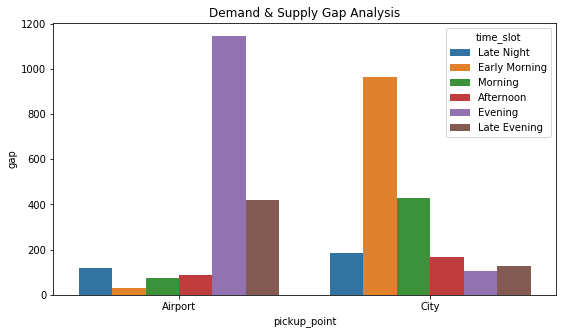

In [232]:
plt.figure('Demand & Supply Gap Analysis',figsize=(9,5))
plt.title('Demand & Supply Gap Analysis')
sns.barplot(x='pickup_point',y='gap',data=Demand_Supply_df,hue='time_slot')
plt.show()

As we see in the Above Chart, maximum Demand and Supply Gap Happens in the Evening & Late Evening (4PM to Midnight) for the rides requested from the Aiport, while the maximum Demand and Supply Gap Happens in the Early Morning & Morning (4AM to 12 Noon) for the rides requested from the City